Team : 11 <br>
Rutvik Patel - DKL, iterative_information_bottleneck <br>
Jay Jatinkumar Patel - DKL, iterative_information_bottleneck <br>
Sai Sri Govind Chennu - I(pA,pB,pAB) <br>

In [8]:
import numpy as np
from matplotlib import pyplot as plt
import math
from scipy.special import rel_entr


In [9]:
# A and B are with the same dimensionality
# A = np.array([0.1,0.5,0.4])
# B = np.array([0.3,0.2,0.1])    

def DKL(A, B):
    """
    Kulback-Leibler divergence D(A||B)
    :param A: pa(x), target distribution
    :param B: pb(x), other distribution
    :return: component-wise DKL(pa(x) || pb(x)), which is a tensor of the same dimensionality as A and B
    :        each entry in the tensor is Ai * ln(Ai / Bi), which means the i-th component of DKL.
    :        this code structure, to return the component-wise Dkl, rather than sum_i Ai*ln(Ai/Bi),
    :        simplifies the update equations and the calculation of MI. 
    :        you will use it in the calculation of mutual information and in the update equations of IB.
    """

    # your code
    # DKL(P,Q) = sum(P .* log.(P ./Q)
    
    # d = np.multiply(A,np.log(np.divide(A,B)))
    d = A * np.log(A/B)
    # d = rel_entr(A,B)    
    # D = d.sum()
    # print(D)
    
    


    # to avoid numerical issues with too small/large beta, check for inf/nan
    d[np.isnan(d)] = 0 # 1e-64
    d[np.isinf(d)] = 0 # 1e-64
    # print(d.shape)
    
    return d
# D = DKL(A,B)
# print(D)

In [10]:
def I(pA, pB, pAB):
    """mutual information I(X,Y) = DKL(P(x,y) || Px x Py)
    :param pA: A - p(a): marginal probability of X
    :param pB: B - p(b): marginal probability of Y
    :param pAB: p(a,b): joint probability of X and Y"""
    # print(pA*pB)
    # print("----------------------------")
    # print(pAB)
    
    # your code (use your DKL function above)
    D = DKL(pAB,pA*pB)
    X = np.sum(D)
    # print(X.shape)
    return X

In [11]:
def entropy(p):
    """entropy of a discrete distribution"""
    ### example for the vectorized calculation of the entropy ###
    return -np.sum(p * np.log(p))


In [12]:
def make_probs(*dims):
    XY = np.random.randn(*dims)
    # make positive
    XY = XY - XY.min()
    # normalize
    XY = XY / XY.sum()
    return XY

In [13]:
def iterative_information_bottleneck(
        Xdim, Ydim, Mmax, Mmin,
        n_iters=100,
        n_tries=3  ,
        n_betas=100,
        beta_min=0.1,
        beta_max=100):

    # working with probabilities as tensors makes it easier to
    # read/write code and lets us utilize numpy broadcasting.
    # e.g, in this function we are working with discrete random
    # variables X, Y, and T. We can represent all probabilities as
    # tensors, where each dimension represents a random variable.

    # e.g. p(x,y) is a tensor of shape (Xdim, Ydim, 1)
    pXY = make_probs(Xdim, Ydim, 1)
    # p(x) is a tensor of shape (Xdim, 1, 1)
    pX = np.sum(pXY, axis=1, keepdims=True)
    # p(y) is a tensor of shape (1, Ydim, 1)
    pY = np.sum(pXY, axis=0, keepdims=True)
    hX = entropy(pX)

    target_MI = I(pX, pY, pXY)
    print("The MI between generated X and Y is:", target_MI)
    print("The entropy of X is:", hX)

    # p(y | x)
    pY_X = pXY / pX

    # Lagrangian
    Ls = np.zeros((Mmax - Mmin+1, n_betas))
    # relevance I(T;Y)
    I_TYs = np.zeros((Mmax - Mmin+1, n_betas))
    # compression I(T;X)
    I_TXs = np.zeros((Mmax - Mmin+1, n_betas))
    # betas
    betas = np.zeros((Mmax - Mmin+1, n_betas))
    # change the cardinality of the features, starting from |T| == |X|m and decreasing by steps on 2
    for m, M in enumerate(range(Mmax, Mmin-1, -2)):
        for i, beta in enumerate(np.linspace(beta_min, beta_max, n_betas)[::-1]):
        # for i,x in enumerate(np.arange(-3,3,0.2)):
            # beta = math.pow(10,x)
            L = np.inf
            I_TX = np.nan
            I_TY = np.nan
            for _ in range(0, n_tries):
                # initialize random p(t | x)
                pT_X = make_probs(Xdim, 1, M)
                # print(pT_X.shape, "pT_X")
                

                # compute pT according to the Bayes rule
                # P_m(t) = sum_x ( p(x) P_m(t | x) )
                pT = np.sum(pX * pT_X, axis=(0,1), keepdims=True)  # T-axis is 2

                # compute p(y | t)
                # P_m(y | t) = sum_x ( P_m(t | x) p(x,y) ) / P_m(t)
                # note: doing this without broadcasting tensors would be less obvious
                pY_T = np.sum(pXY * pT_X / pT, axis=0, keepdims=True)

                for _ in range(0, n_iters): # the problem is not convex, so we try a few times.
                    ############# IB update

                    # write your code for: pT_X
                    #print(DKL(pY_X,pY_T))
                    # print(pT.shape,"pT")
                    
                    Z_X = np.sum(pT* np.exp((-1)*beta*np.sum(DKL(pY_X,pY_T),axis=1,keepdims=True)),axis=2,keepdims=True) 
                    pT_X = (pT* np.exp((-1)*beta*np.sum(DKL(pY_X,pY_T),axis=1,keepdims=True)))/Z_X
                    # write your code for: pT
                    pT = np.sum(pX * pT_X, axis=(0,1), keepdims=True)
                    # write your code for: pY_T
                    pY_T = np.sum(pXY * pT_X / pT, axis=0, keepdims=True)
                    
#                     print("T----------------------------------")
#                     print(pT)
#                     print("T_X----------------------------------")
                    # print(pT_X.shape)
#                     print("Y_T----------------------------------")
#                     print(pY_T)
                    

                    I_TX_ = I(pT, pX, pT_X * pX) # calculate I[T; X]
                    # print(I_TX_)
                    I_TY_ = I(pT, pY, pY_T * pT) # calculate I[T; Y]
                    # print(I_TY_)
                    L_ = I_TX_ - I_TY_ * beta    # calculate the objective of IB
                    # print(L_)
                    if L_ < L: # find find the minimum within n_iters. we need it because the problem is not convex
                        L = L_
                        I_TX = I_TX_
                        I_TY = I_TY_

            # save minimum L, corresponding beta, and mutual information tx and ty
            # print("m",m)
            # print("i",i)
            Ls[m, i] = L
            I_TXs[m, i] = I_TX
            I_TYs[m, i] = I_TY
            betas[m, i] = beta

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # relevance-compression curves
    axs[0].set_title("Lagrangian Temperature Relevance-Compression Curves")
    axs[0].set_xlabel("I(T;X)/H(X)")
    axs[0].set_ylabel("I(T;Y)/I(Y;X)")
    for i, (itx, ity, ls) in enumerate(zip(I_TXs, I_TYs, Ls)):
        axs[0].scatter(itx / hX, ity / target_MI, label=f"M:{Mmax - i}", s=5, c=ls, cmap="plasma")

    axs[1].set_title("Beta Temperature Relevance-Compression Curves")
    axs[1].set_xlabel("I(T;X)/H(X)")
    axs[1].set_ylabel("I(T;Y)/I(Y;X)")
    for i, (itx, ity, bs) in enumerate(zip(I_TXs, I_TYs, betas)):
        axs[1].scatter(itx / hX, ity / target_MI, label=f"M:{Mmax - i}", s=5, c=bs, cmap="RdYlBu_r")

    axs[2].set_title("Relevance-Compression Curves")
    axs[2].set_xlabel("I(T;X)/H(X)")
    axs[2].set_ylabel("I(T;Y)/I(Y;X)")
    for i, (itx, ity) in enumerate(zip(I_TXs, I_TYs)):
        axs[2].scatter(itx / hX, ity / target_MI, label=f"M:{Mmax - i}", s=5)
    axs[2].legend()

    fig.tight_layout()
    plt.show()

The MI between generated X and Y is: 0.08480533284153345
The entropy of X is: 2.278784534992502


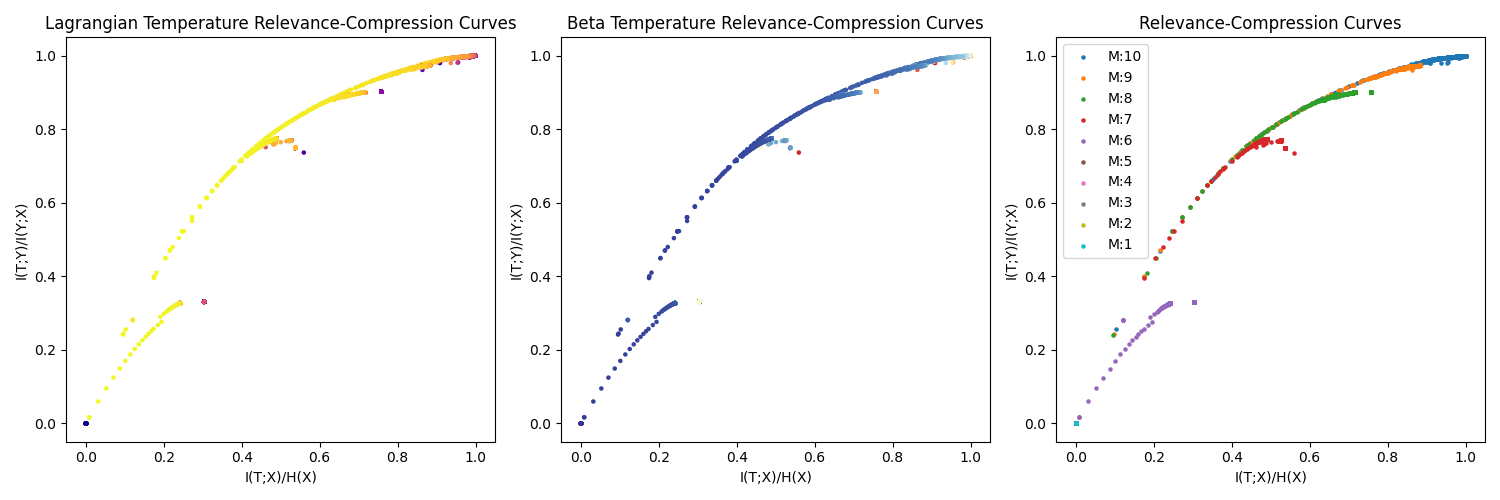

In [14]:
if __name__ == '__main__':
    iterative_information_bottleneck(
        Xdim=10,
        Ydim=5,
        Mmax=10, # the same cardinality as in the original X
        Mmin=1, # everything is collapsed to a single cluster
        n_iters=100,
        n_tries=100,
        n_betas=1000,
        beta_min=0.1,
        beta_max=1000
    )